In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

data = pd.read_csv("Dry_Bean_Dataset.csv")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
classes = np.unique(y)
y_int = np.array([np.where(classes == label)[0][0] for label in y])

print("Splitting data into train/val/test sets...")
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_int, test_size=0.3, random_state=42, stratify=y_int)
orig_counts = Counter(y_trainval)
print("Original train class distribution:", orig_counts)


smote = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=42)
X_train, y_train = smote.fit_resample(X_trainval, y_trainval)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

# Define parameter grid for common hyperparameters (including regularization)
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_lambda': [1, 2],  # L2 regularization (default is 1)
    'reg_alpha': [0, 1]    # L1 regularization (default is 0)
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best hyperparameters:")
print(grid.best_params_)
import matplotlib.pyplot as plt

# Fit the final model with best parameters on the full training set
final_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    n_jobs=-1,
    **grid.best_params_
)
final_model.fit(X_train, y_train)

# Prepare y_encoded for the whole dataset (aligning with y_int)
y_encoded = y_int

# Define datasets and their names for iteration
datasets = [
    ("Train set", X_train, y_train),
    ("Test set", X_test, y_test),
    ("Whole dataset", X, y_encoded)
]

for name, X_set, y_set in datasets:
    y_pred = final_model.predict(X_set)
    accuracy = final_model.score(X_set, y_set) * 100
    print(f"{name} accuracy: {accuracy:.2f}%")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_set, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Classification report for {name.lower()}:")
    print(classification_report(y_set, y_pred, target_names=classes))
    
    # Binarize the output for ROC curve (one-vs-rest)
    y_bin = label_binarize(y_set, classes=range(len(classes)))
    if hasattr(final_model, "predict_proba"):
        y_score = final_model.predict_proba(X_set)
    else:
        y_score = final_model.decision_function(X_set)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate and print average AUC
    average_auc = np.mean([roc_auc[i] for i in range(len(classes))])
    print(f'Average AUC ({name.lower()}): {average_auc:.4f}')


from sklearn.decomposition import PCA

# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit XGBClassifier on PCA-reduced data for visualization
model_vis = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    n_jobs=-1,
    n_estimators=grid.best_params_["n_estimators"],
    learning_rate=grid.best_params_["learning_rate"],
    max_depth=grid.best_params_["max_depth"],
    subsample=grid.best_params_["subsample"],
    colsample_bytree=grid.best_params_["colsample_bytree"],
    gamma=grid.best_params_["gamma"],
    reg_lambda=grid.best_params_["reg_lambda"],
    reg_alpha=grid.best_params_["reg_alpha"],
    random_state=42
)
model_vis.fit(X_pca, y_int)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_int, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (PCA projection) - Whole Dataset')

# Add legend
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, classes, title="Classes", loc="best")

plt.show()




Original train class distribution: Counter({3: 2503, 6: 1837, 5: 1408, 4: 1340, 2: 1151, 0: 927, 1: 361})
Best hyperparameters found by GridSearchCV:
{'C': 100.0, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Train set accuracy: 94.22%


c:\Users\angel\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


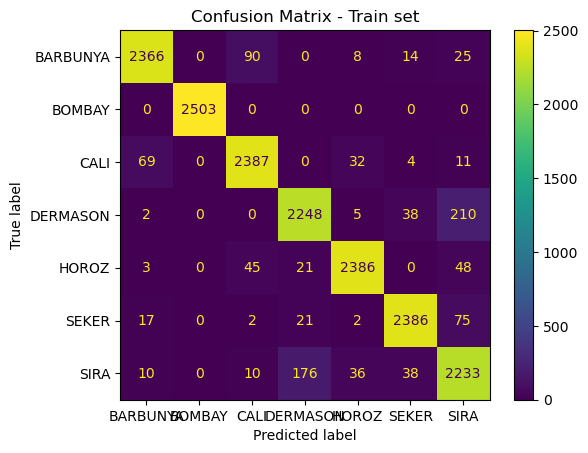

Classification report for train set:
              precision    recall  f1-score   support

    BARBUNYA       0.96      0.95      0.95      2503
      BOMBAY       1.00      1.00      1.00      2503
        CALI       0.94      0.95      0.95      2503
    DERMASON       0.91      0.90      0.90      2503
       HOROZ       0.97      0.95      0.96      2503
       SEKER       0.96      0.95      0.96      2503
        SIRA       0.86      0.89      0.87      2503

    accuracy                           0.94     17521
   macro avg       0.94      0.94      0.94     17521
weighted avg       0.94      0.94      0.94     17521



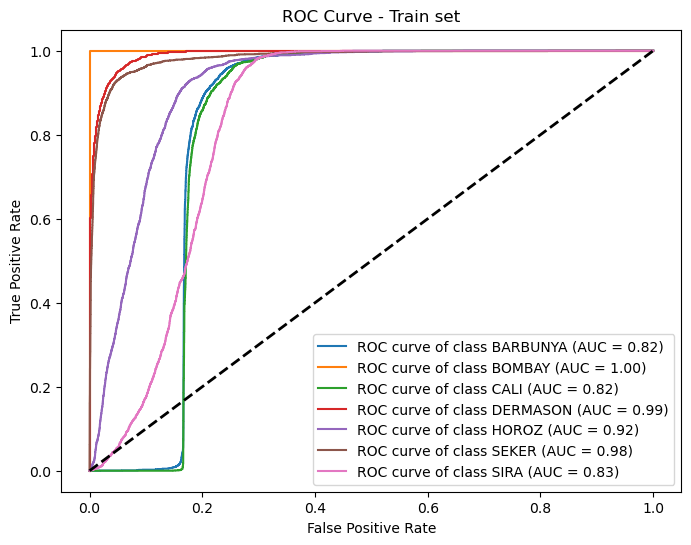

Average AUC (train set): 0.9085
Test set accuracy: 92.09%


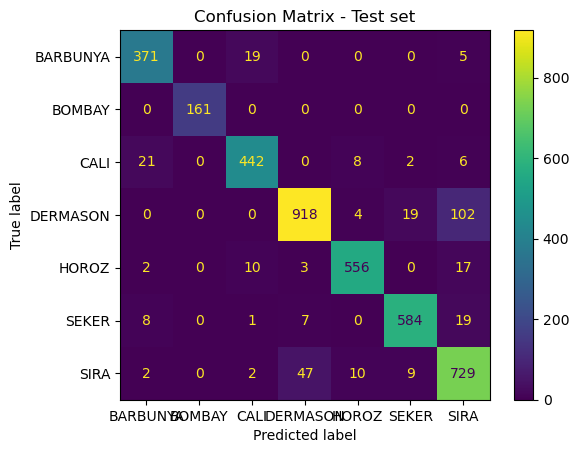

Classification report for test set:
              precision    recall  f1-score   support

    BARBUNYA       0.92      0.94      0.93       395
      BOMBAY       1.00      1.00      1.00       161
        CALI       0.93      0.92      0.93       479
    DERMASON       0.94      0.88      0.91      1043
       HOROZ       0.96      0.95      0.95       588
       SEKER       0.95      0.94      0.95       619
        SIRA       0.83      0.91      0.87       799

    accuracy                           0.92      4084
   macro avg       0.93      0.93      0.93      4084
weighted avg       0.92      0.92      0.92      4084



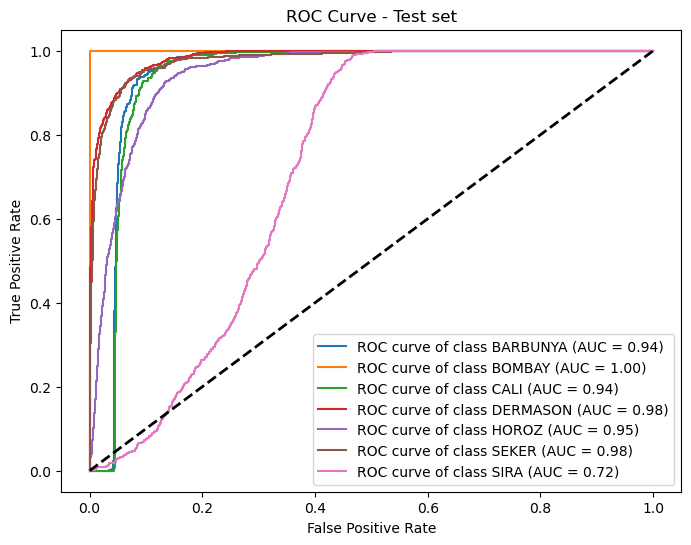

Average AUC (test set): 0.9301
Whole dataset accuracy: 92.23%


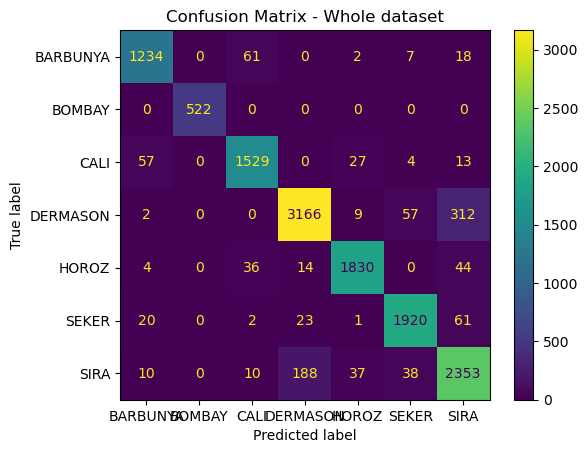

Classification report for whole dataset:
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.93      0.93      1322
      BOMBAY       1.00      1.00      1.00       522
        CALI       0.93      0.94      0.94      1630
    DERMASON       0.93      0.89      0.91      3546
       HOROZ       0.96      0.95      0.95      1928
       SEKER       0.95      0.95      0.95      2027
        SIRA       0.84      0.89      0.87      2636

    accuracy                           0.92     13611
   macro avg       0.93      0.94      0.94     13611
weighted avg       0.92      0.92      0.92     13611



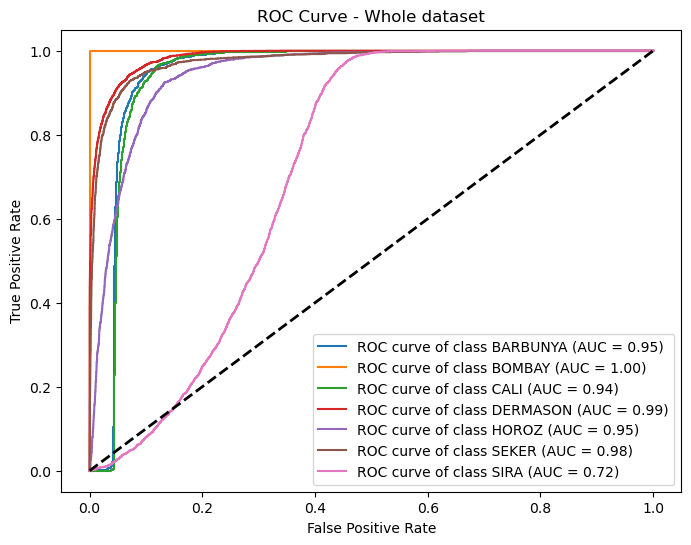

Average AUC (whole dataset): 0.9305


C:\Users\angel\AppData\Local\Temp\ipykernel_15628\1682950698.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
C:\Users\angel\AppData\Local\Temp\ipykernel_15628\1682950698.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)


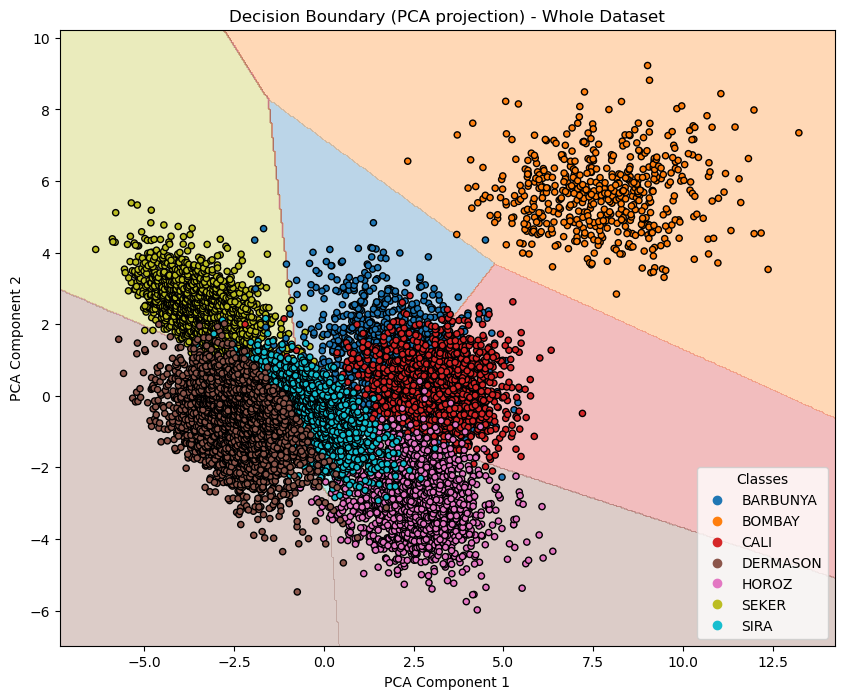

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE
#set random seed for reproducibility
np.random.seed(42)

#load and preprocess the data
data = pd.read_csv("Dry_Bean_Dataset.csv")
#features
X = data.iloc[:, :-1].values  
#targets
y = data.iloc[:, -1].values 

#normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

#convert labels to integers
classes = np.unique(y)
y = np.array([np.where(classes == label)[0][0] for label in y])

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
orig_counts = Counter(y_train)
print("Original train class distribution:", orig_counts)


smote = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
#define parameter grid for GridSearchCV
param_grid = {'C': [1/0.01, 1/0.1, 1/0.5],'max_iter': [1000, 3000, 5000],'solver': ['lbfgs'],'multi_class': ['multinomial']}# C relates to learning rate

#logistic regression with GridSearchCV
logreg = LogisticRegression()
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best hyperparameters found by GridSearchCV:")
print(grid.best_params_)

#define datasets and their names for iteration
datasets = [
    ("Train set", X_train, y_train),
    ("Test set", X_test, y_test),
    ("Whole dataset", X, y)
]

for name, X_set, y_set in datasets:
    y_pred = grid.predict(X_set)
    accuracy = grid.score(X_set, y_set) * 100
    print(f"{name} accuracy: {accuracy:.2f}%")
    
    #plot confusion matrix
    cm = confusion_matrix(y_set, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    print(f"Classification report for {name.lower()}:")
    print(classification_report(y_set, y_pred, target_names=classes))
    
    #binarize the output for ROC curve (one-vs-rest)
    y_bin = label_binarize(y_set, classes=range(len(classes)))
    y_score = grid.decision_function(X_set)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    #plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    #calculate and print average AUC
    average_auc = np.mean(list(roc_auc.values())[:-1])  # exclude 'micro'
    print(f'Average AUC ({name.lower()}): {average_auc:.4f}')

#reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

#fit logistic regression on PCA-reduced data for visualization
logreg_vis = LogisticRegression(
    C=grid.best_params_['C'],
    max_iter=grid.best_params_['max_iter'],
    solver=grid.best_params_['solver'],
    multi_class=grid.best_params_['multi_class']
)
logreg_vis.fit(X_pca, y)

#create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = logreg_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (PCA projection) - Whole Dataset')

#add legend
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, classes, title="Classes", loc="best")

plt.show()

